In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import linregress
import datetime
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm

# Pairs Trading Strategy BTC-ETH

## Data Gathering

Scan for dates with fully available data

In [2]:
def check_date(date, assets):
    end_date = date + datetime.timedelta(days=1)
    instrument_str = " ".join(assets)
    price_data = yf.download(instrument_str, start=date, end=end_date,  interval = '1m', progress=False, show_errors=False)
    nan_stats = price_data['Adj Close'].isna().sum()
    return price_data, nan_stats.sum()

In [3]:
assets = ['BTC-USD', 'ETH-USD']

In [4]:
start_date = datetime.date(2022, 12, 5)
for i in range(27):
    date = start_date + datetime.timedelta(days=i)
    data, nans = check_date(date, assets)
    print(f'{date}: datapoints {len(data)}, missing values {nans:.0f}')

2022-12-05: datapoints 0, missing values 0
2022-12-06: datapoints 1406, missing values 38
2022-12-07: datapoints 1396, missing values 45
2022-12-08: datapoints 1416, missing values 35
2022-12-09: datapoints 1423, missing values 29
2022-12-10: datapoints 1424, missing values 26
2022-12-11: datapoints 1415, missing values 21
2022-12-12: datapoints 1415, missing values 32
2022-12-13: datapoints 1421, missing values 30
2022-12-14: datapoints 1418, missing values 12
2022-12-15: datapoints 1421, missing values 27
2022-12-16: datapoints 1417, missing values 23
2022-12-17: datapoints 1423, missing values 26
2022-12-18: datapoints 1418, missing values 20
2022-12-19: datapoints 1420, missing values 39
2022-12-20: datapoints 1429, missing values 2
2022-12-21: datapoints 1432, missing values 0
2022-12-22: datapoints 1434, missing values 0
2022-12-23: datapoints 1429, missing values 0
2022-12-24: datapoints 1429, missing values 0
2022-12-25: datapoints 1437, missing values 0
2022-12-26: datapoints 

Download from Yahoo Finance

In [5]:
date = datetime.datetime(2022, 12, 26)
end_date = date + datetime.timedelta(days=1)
price_data = yf.download(" ".join(assets), start=date, end=end_date,  interval = '1m')
adjclose = price_data['Adj Close']
adjclose

[*********************100%***********************]  2 of 2 completed


,BTC-USD,ETH-USD
Datetime,,
2022-12-26 00:00:00,16842.250000,1218.920166
2022-12-26 00:01:00,16841.634766,1218.788818
2022-12-26 00:02:00,16840.742188,1218.675781
2022-12-26 00:03:00,16841.238281,1218.585815
2022-12-26 00:04:00,16839.712891,1218.458252
...,...,...
2022-12-26 23:54:00,16896.162109,1225.294800
2022-12-26 23:55:00,16904.869141,1226.134766
2022-12-26 23:56:00,16912.722656,1226.687500


Check for missing data

In [6]:
nan_stats = price_data.isna().sum()
nan_stats

Adj Close  BTC-USD    0
           ETH-USD    0
Close      BTC-USD    0
           ETH-USD    0
High       BTC-USD    0
           ETH-USD    0
Low        BTC-USD    0
           ETH-USD    0
Open       BTC-USD    0
           ETH-USD    0
Volume     BTC-USD    0
           ETH-USD    0
dtype: int64

In [7]:
if nan_stats.sum() > 0:
    raise ValueError("Data contains NaN values")

Since there are no NaN values, we are good to go ahead.

In [8]:
adjclose.describe()

,BTC-USD,ETH-USD
count,1436.000000,1436.000000
mean,16856.561965,1219.044945
std,18.398011,2.111365
min,16812.369141,1214.335938
25%,16844.250488,1217.554535
50%,16852.781250,1219.348267
75%,16867.033203,1220.645630
max,16920.123047,1226.849609


In [9]:
price_data['Open'].iloc[0]

BTC-USD    16842.250000
ETH-USD     1218.920166
Name: 2022-12-26 00:00:00, dtype: float64

In [10]:
adjclose.iloc[-1]

BTC-USD    16920.123047
ETH-USD     1226.849609
Name: 2022-12-26 23:58:00, dtype: float64

## Estimation of Correlation Coefficient

In [11]:
lr1 = np.log(adjclose.iloc[:, 0] / adjclose.iloc[:, 0].shift(1))[1:] # ignore NaN at the start due to shift
lr2 = np.log(adjclose.iloc[:, 1] / adjclose.iloc[:, 1].shift(1))[1:] # ignore NaN at the start due to shift
rho = lr1.corr(lr2)
rho

0.6314643099514033

## Estimation of Cointegration Coefficient

Engle-Granger test for cointegration

In [12]:
coint_results = ts.coint(np.log(adjclose.iloc[:, 0]), np.log(adjclose.iloc[:, 1]))
print(f't-stat: {coint_results[0]}\np-value: {coint_results[1]}\ncritical values [1%, 5%, 10%]: {coint_results[2]}')

t-stat: -2.2089686745056
p-value: 0.4197434813784847
critical values [1%, 5%, 10%]: [-3.90408827 -3.34039122 -3.04740686]


Since the p-value is significantly above even 10%, time series are not likely to be cointegrated.  
The analysis is nevertheless continued because it was requested

In [13]:
model = sm.OLS(np.log(adjclose.iloc[:, 0]), np.log(adjclose.iloc[:, 1]))
result = model.fit()
beta = result.params[0]
beta

1.3696508334454354

## Estimation of other inputs

### Estimated parameters

In [14]:
trading_time = 1440 # in minutes
M = len(adjclose)
S1_0 = price_data['Open'].iloc[:, 0][0] # opening price for BTC
S2_0 = price_data['Open'].iloc[:, 1][0] # opening price for ETH
mu1 = lr1.mean() * trading_time # mean return over the whole observation period
mu2 = lr2.mean() * trading_time # mean return over the whole observation period
sigma1 = lr1.std() * np.sqrt(trading_time) # volatility over the whole observation period
sigma2 = lr2.std() * np.sqrt(trading_time) # volatility over the whole observation period
print(f'{M=}, {S1_0=}, {S2_0=}, {mu1=}, {mu2=}, {sigma1=}, {sigma2=}')

M=1436, S1_0=16842.25, S2_0=1218.920166015625, mu1=0.004629089311942933, mu2=0.006506826637331203, sigma1=0.003820899600423643, sigma2=0.00451898016910497


### Manually set parameters

In [15]:
z_0 = 0.00 # initial spread, 
gamma = 0.6 # risk aversion coefficient
T = 1 # trading horizon, whole day = 1
dt = T/M
delta = 1 # speed of mean reversion

## Price

Initialize simulation

In [16]:
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi1 = np.zeros((M + 1, 1))
Pi2 = np.zeros((M + 1, 1))

Simulate z over time period

In [17]:
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma1 ** 2 + beta ** 2 * sigma2 ** 2 + 2 * beta * sigma1 * sigma2 * rho)
eta = (-1/delta) * (mu1 - sigma1 ** 2/2 + beta*(mu2 - sigma2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma1 + beta * sigma2 * rho)/ sigma_beta * rn1[t] + beta * (sigma2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = adjclose.iloc[:, 0][t-1]
    S2[t] = adjclose.iloc[:, 1][t-1]

## Plot Price

Styles

In [18]:
colors = ['m', 'y']
font = {'family': 'sans-serif',
        'color':  'b',
        'weight': 'bold',
        'size': 16,
        }

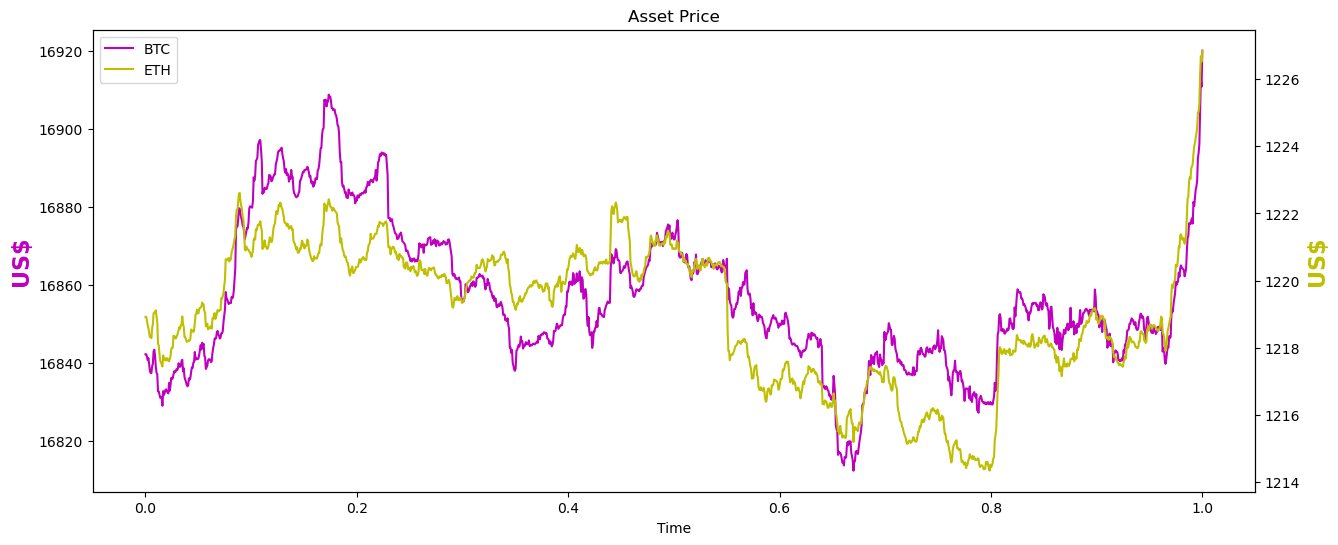

In [19]:
labels = [c.replace('-USD','').replace('.SW','') for c in adjclose.columns]
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(tt, S1, colors[0], lw=1.5, label=labels[0])
lns2 = ax2.plot(tt, S2, colors[1], lw=1.5, label=labels[1])
ax1.set_xlabel('Time')
ax1.set_ylabel('US$',fontdict=font, color=colors[0])
ax2.set_ylabel('US$',fontdict=font, color=colors[1])

leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc=0)

plt.title('Asset Price')
plt.show()

Text(0.5, 1.0, 'z')

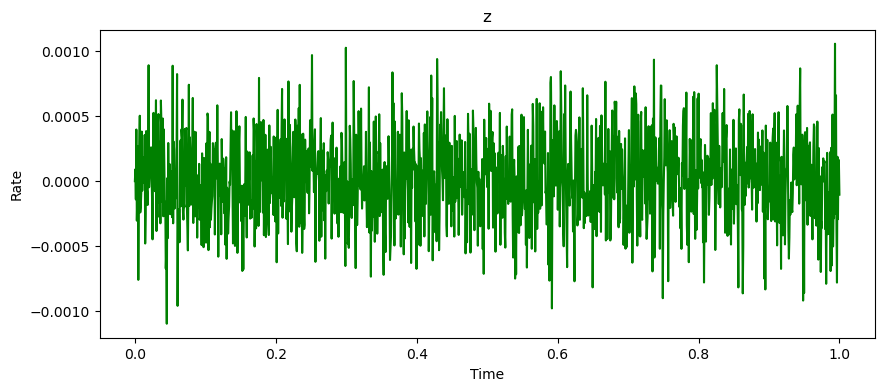

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('z')

## Optimal Trading Weights

In [21]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma1 ** 2 + beta * sigma2 ** 2)/((1 - rho ** 2) * sigma1 ** 2) - rho * mu2 * (T - t * dt)/((1 - rho **2) * sigma1 * sigma2)
    c[t] = 0.5 * mu2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma1 ** 2 + beta * sigma2 ** 2 + 2 * sigma1 * sigma2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu2 * delta * rho * (sigma1 ** 2 + beta * sigma2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma1 ** 2 + beta * sigma2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma1 ** 2)
    Pi1[t] = (1 / S1[t]) * ((mu1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma1 ** 2) + delta/gamma * (-2 * a[t] * (mu1 + delta * z[t])-b[t]) - rho * mu2/(gamma * (1 - rho ** 2) * sigma1 * sigma2))
    Pi2[t] = (1 / S2[t]) * (mu2 / (gamma * (1 - rho ** 2) * sigma2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu1 + delta * z[t]) - b[t]) - rho * (mu1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma1 * sigma2))

Text(0.5, 1.0, 'Weights')

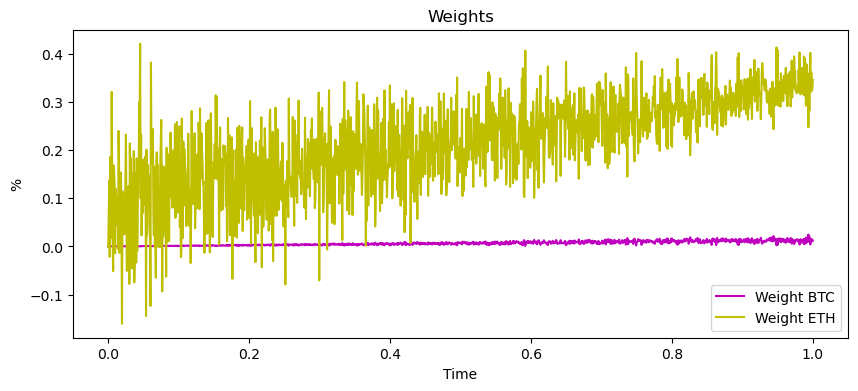

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(tt, Pi1, colors[0], lw=1.5, label=f'Weight {labels[0]}')
plt.plot(tt, Pi2, colors[1], lw=1.5, label=f'Weight {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

## Optimal Cash Process

Text(0.5, 1.0, 'Cash process')

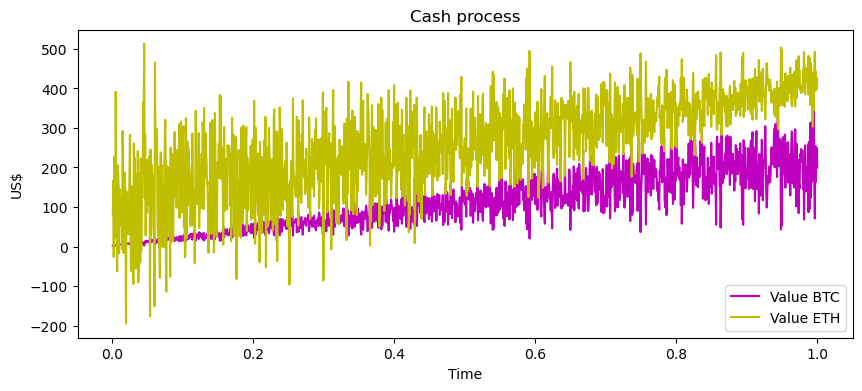

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], Pi1[1:]*S1[1:], colors[0], lw=1.5, label=f'Value {labels[0]}')
plt.plot(tt[1:], Pi2[1:]*S2[1:], colors[1], lw=1.5, label=f'Value {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Cash process')

In [24]:
wealth_dynamic = np.abs(Pi1)*S1+np.abs(Pi2)*S2

Text(0.5, 1.0, 'Wealth')

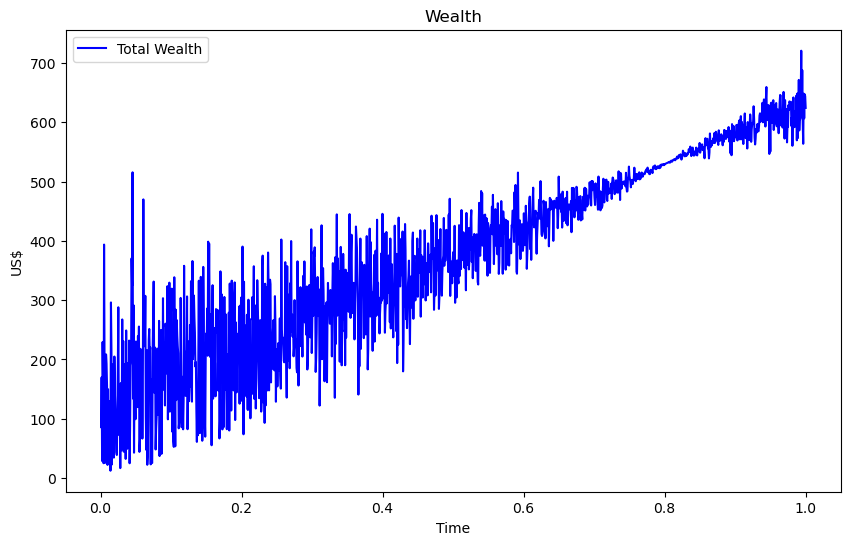

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], wealth_dynamic[1:], 'b', lw=1.5, label='Total Wealth')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Wealth')

## Static Control Pair

In [26]:
wealth_static = np.mean(Pi1)*S1+np.mean(Pi2)*S2

Text(0.5, 1.0, 'Total Wealth')

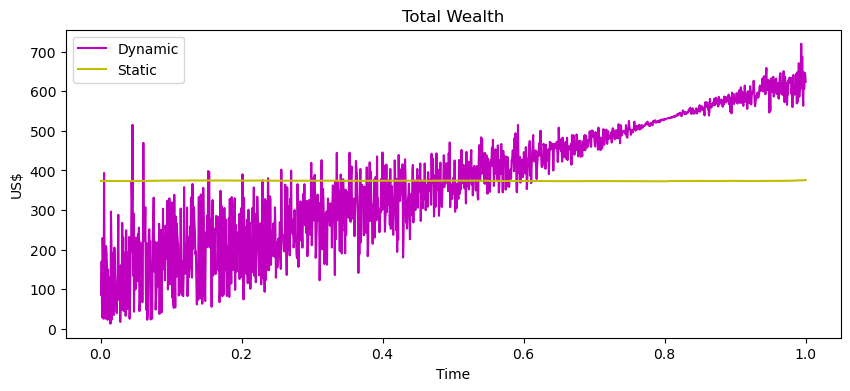

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], wealth_dynamic[1:], colors[0], lw=1.5, label='Dynamic')
plt.plot(tt[1:], wealth_static[1:], colors[1], lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Total Wealth')

In [28]:
dyn_return = 100*(wealth_dynamic[-1]/wealth_dynamic[1] - 1)
f'{float(dyn_return):.2f}%'

'626.44%'

In [29]:
stat_return = 100*(wealth_static[-1]/wealth_static[1] -1)
f'{float(stat_return):.2f}%'

'0.59%'

# Simulated prices for BTC and ETH

In [30]:
lr1 = np.log(adjclose.iloc[:, 0] / adjclose.iloc[:, 0].shift(1))[1:] # ignore NaN at the start due to shift
lr2 = np.log(adjclose.iloc[:, 1] / adjclose.iloc[:, 1].shift(1))[1:] # ignore NaN at the start due to shift
rho = lr1.corr(lr2)
rho

0.6314643099514033

In [31]:
beta, z_inter, *_ = linregress(np.log(adjclose.iloc[:, 0]), np.log(adjclose.iloc[:, 1]))
beta

1.306408841644147

## Parameters

In [32]:
M = 1440                   # steps
T = 1                      # trading horizon, whole day = 1
dt = T/M                   # delta t
S1_0 = 16842               # opening price for BTC
S2_0 = 1218.9              # opening price for ETH
mu1 = 0.004629             # mean return over the whole observation period
mu2 = 0.006507             # mean return over the whole observation period
sigma1 = 0.003821          # volatility over the whole observation period
sigma2 = 0.004519          # volatility over the whole observation period
beta = 0.1354              # cointegration coefficient
rho = 0.4774               # correlation coefficient
delta = 1                  # speed of mean reversion
gamma = 0.6                # risk aversion coefficient

## Price

Initialize simulation

In [37]:
sS1 = np.zeros((M + 1, 1))
sS2 = np.zeros((M + 1, 1))
sz =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
sPi1 = np.zeros((M + 1, 1))
sPi2 = np.zeros((M + 1, 1))

Simulate z over time period

In [38]:
tt = np.linspace(0, 1, M + 1)
sz[0] = z_0
sS1[0] = S1_0
sS2[0] = S2_0
sigma_beta = np.sqrt(sigma1 ** 2 + beta ** 2 * sigma2 ** 2 + 2 * beta * sigma1 * sigma2 * rho)
eta = (-1/delta) * (mu1 - sigma1 ** 2/2 + beta*(mu2 - sigma2 ** 2/2))
rn = np.random.standard_normal(sz.shape)
rn1 = np.random.standard_normal(sS1.shape) 
rn2 = np.random.standard_normal(sS2.shape) 
for t in range(1, M + 1):
    sz[t] = z[t-1]* (1 - delta * (eta - sz[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma1 + beta * sigma2 * rho)/ sigma_beta * rn1[t] + beta * (sigma2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    sS1[t] = sS1[t-1] * np.exp((mu1 + delta * sz[t] - sigma1 ** 2 / 2) * dt + sigma1 * np.sqrt(dt) * rn1[t])
    sS2[t] = sS2[t-1] * np.exp((mu2 - sigma2 ** 2 / 2) * dt + sigma2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

## Plot Price

Styles

In [39]:
colors = ['m', 'y']
font = {'family': 'sans-serif',
        'color':  'b',
        'weight': 'bold',
        'size': 16,
        }

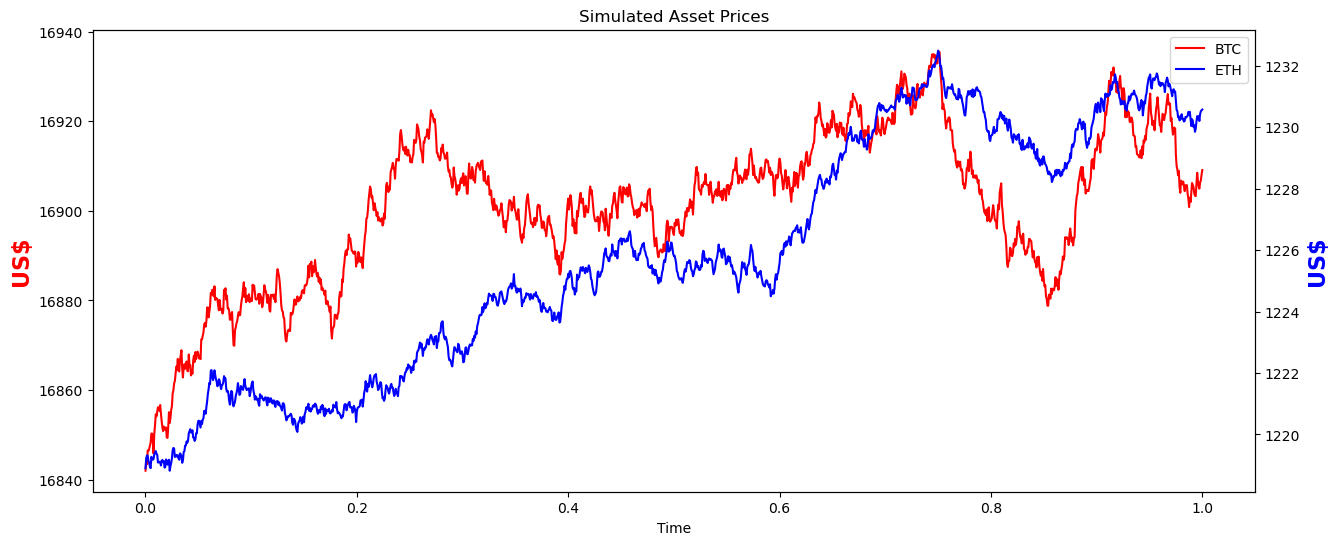

In [51]:
labels = [c.replace('-USD','') for c in adjclose.columns]
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(tt, sS1, 'r', lw=1.5, label=labels[0])
lns2 = ax2.plot(tt, sS2, 'b', lw=1.5, label=labels[1])
ax1.set_xlabel('Time')
ax1.set_ylabel('US$',fontdict=font, color='r')
ax2.set_ylabel('US$',fontdict=font, color='b')

leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc=0)

plt.title('Simulated Asset Prices')
plt.show()

Text(0.5, 1.0, 'Simulated z')

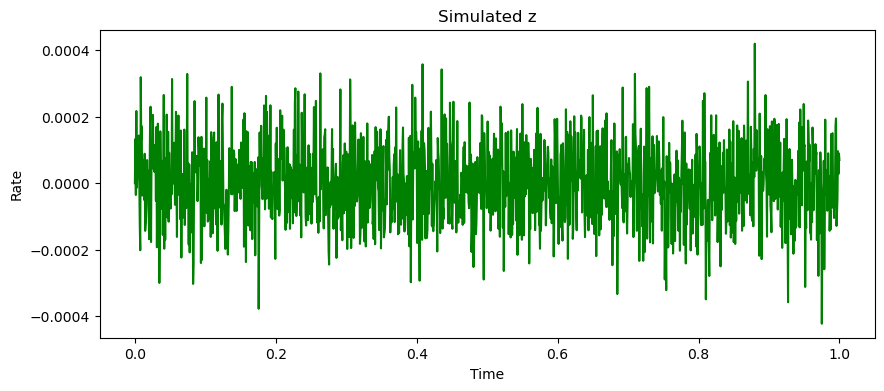

In [41]:
plt.figure(figsize=(10, 4))
plt.plot(tt, sz, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Simulated z')

## Optimal Trading Weights

In [42]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma1 ** 2 + beta * sigma2 ** 2)/((1 - rho ** 2) * sigma1 ** 2) - rho * mu2 * (T - t * dt)/((1 - rho **2) * sigma1 * sigma2)
    c[t] = 0.5 * mu2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma1 ** 2 + beta * sigma2 ** 2 + 2 * sigma1 * sigma2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu2 * delta * rho * (sigma1 ** 2 + beta * sigma2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma1 ** 2 + beta * sigma2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma1 ** 2)
    sPi1[t] = (1 / sS1[t]) * ((mu1 + delta * sz[t])/(gamma * (1 - rho ** 2) * sigma1 ** 2) + delta/gamma * (-2 * a[t] * (mu1 + delta * sz[t])-b[t]) - rho * mu2/(gamma * (1 - rho ** 2) * sigma1 * sigma2))
    sPi2[t] = (1 / sS2[t]) * (mu2 / (gamma * (1 - rho ** 2) * sigma2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu1 + delta * sz[t]) - b[t]) - rho * (mu1 + delta * sz[t]) / (gamma * (1 - rho ** 2) * sigma1 * sigma2))

Text(0.5, 1.0, 'Simluated Weights')

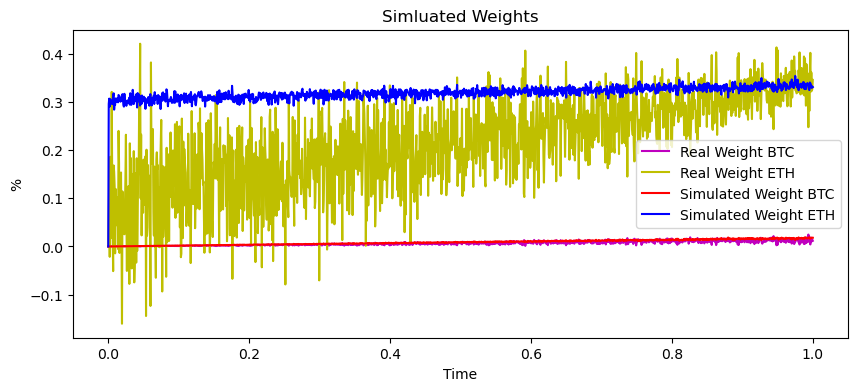

In [57]:
t_space = np.linspace(0, 1, len(Pi1))
plt.figure(figsize=(10, 4))
plt.plot(t_space, Pi1, colors[0], lw=1.5, label=f'Real Weight {labels[0]}')
plt.plot(t_space, Pi2, colors[1], lw=1.5, label=f'Real Weight {labels[1]}')
plt.plot(tt, sPi1, 'r', lw=1.5, label=f'Simulated Weight {labels[0]}')
plt.plot(tt, sPi2, 'b', lw=1.5, label=f'Simulated Weight {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Simluated Weights')

## Optimal Cash Process

Text(0.5, 1.0, 'Simluated Cash')

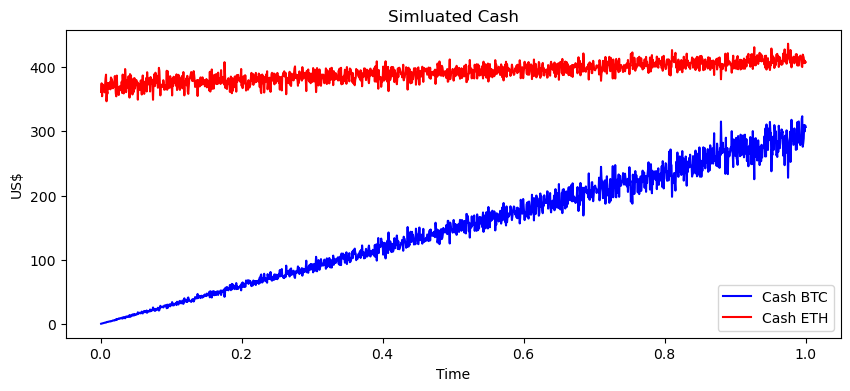

In [59]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], sPi1[1:]*sS1[1:], 'b', lw=1.5, label=f'Cash {labels[0]}')
plt.plot(tt[1:], sPi2[1:]*sS2[1:], 'r', lw=1.5, label=f'Cash {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Simluated Cash')

In [45]:
s_wealth_dynamic = np.abs(sPi1)*sS1+np.abs(sPi2)*sS2

Text(0.5, 1.0, 'Simulated Wealth')

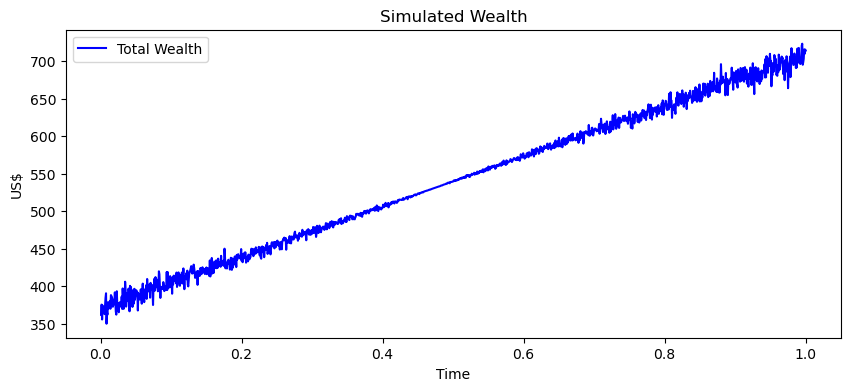

In [60]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], s_wealth_dynamic[1:], 'b', lw=1.5, label='Total Wealth')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Simulated Wealth')

## Static Control Pair

In [47]:
s_wealth_static = np.mean(sPi1)*sS1+np.mean(sPi2)*sS2

Text(0.5, 1.0, 'Total Wealth')

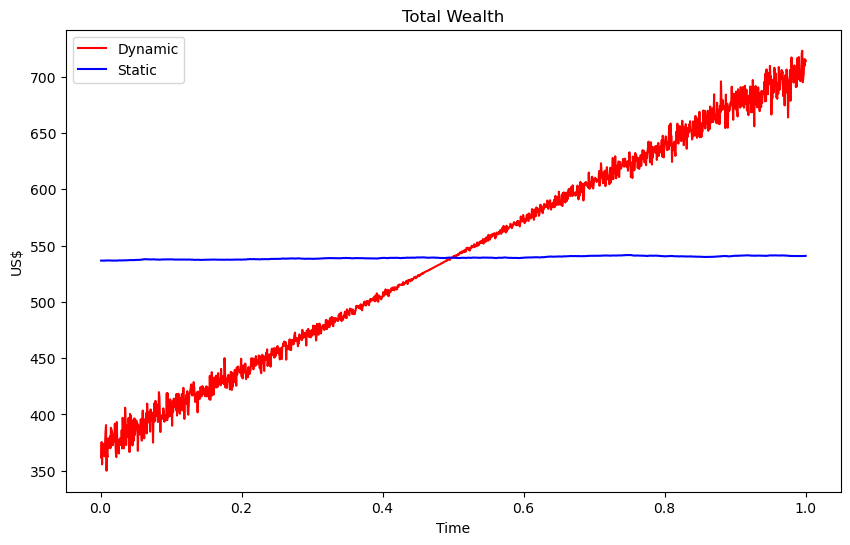

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], s_wealth_dynamic[1:], 'r', lw=1.5, label='Dynamic')
plt.plot(tt[1:], s_wealth_static[1:], 'b', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Total Wealth')

In [61]:
s_wealth_dynamic[-1]/s_wealth_dynamic[1] - 1

array([0.97256214])

In [62]:
s_wealth_static[-1]/s_wealth_static[1] - 1

array([0.00781496])